# Descriptive Analytics

**Goal:** To understand what is happening across multiple dimensions

**Focus Areas:**
- Growth Trajectory & Olist Maturity
- Budget vs Premium Order dynamics
- Product Category Performance
- Urban vs Rural Patterns
- Delivery delay impact quantification. 

In [2]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy import stats

# Settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# db connection
conn = sqlite3.connect('../data/ecommerce.db')
print('Connected to database')

Connected to database


### 1. Growth & Platform Maturity

#### 1.1 Platform Evaluation

In [5]:
# Monthly Metrics

growth_query = """
SELECT
    strftime('%Y-%m', order_purchase_timestamp) AS month,
    COUNT(*) AS num_orders,
    COUNT(DISTINCT customer_id) AS unique_customers,
    ROUND(AVG(total_order_value), 2) AS avg_order_value,
    ROUND(SUM(total_order_value), 2) AS total_revenue,
    ROUND(AVG(review_score), 2) AS avg_review,
    ROUND(AVG(delivery_delay_days), 2) AS avg_delay_days,
    ROUND(SUM(is_delayed) * 100.0 / COUNT(*), 2) AS delay_rate
FROM order_analysis
WHERE order_status = 'delivered'
GROUP BY month
ORDER BY month;
"""

growth_df = pd.read_sql_query(growth_query, conn)
growth_df['month'] = pd.to_datetime(growth_df['month'])

print("Monthly Biz Metrics:")
print(growth_df.head(10))

Monthly Biz Metrics:
       month  num_orders  unique_customers  avg_order_value  total_revenue  \
0 2016-09-01           1                 1           143.46         143.46   
1 2016-10-01         265               265           176.12       46671.48   
2 2016-12-01           1                 1            19.62          19.62   
3 2017-01-01         750               750           171.27      128454.10   
4 2017-02-01        1653              1653           164.95      272657.26   
5 2017-03-01        2546              2546           163.52      416327.30   
6 2017-04-01        2303              2303           169.99      391484.45   
7 2017-05-01        3546              3546           160.98      570837.90   
8 2017-06-01        3135              3135           157.62      494147.47   
9 2017-07-01        3872              3872           147.22      570027.48   

   avg_review  avg_delay_days  delay_rate  
0        1.00           36.32      100.00  
1        4.01          -36.08   


Platform Phases:
               month num_orders                avg_review delay_rate
               count        min   max     mean       mean       mean
phase                                                               
Early Growth       4          1   750   254.25       3.55      26.05
Growth Phase       3       1653  2546  2167.33       4.17       5.55
Maturity Phase    16       3135  7289  5559.94       4.17       7.57


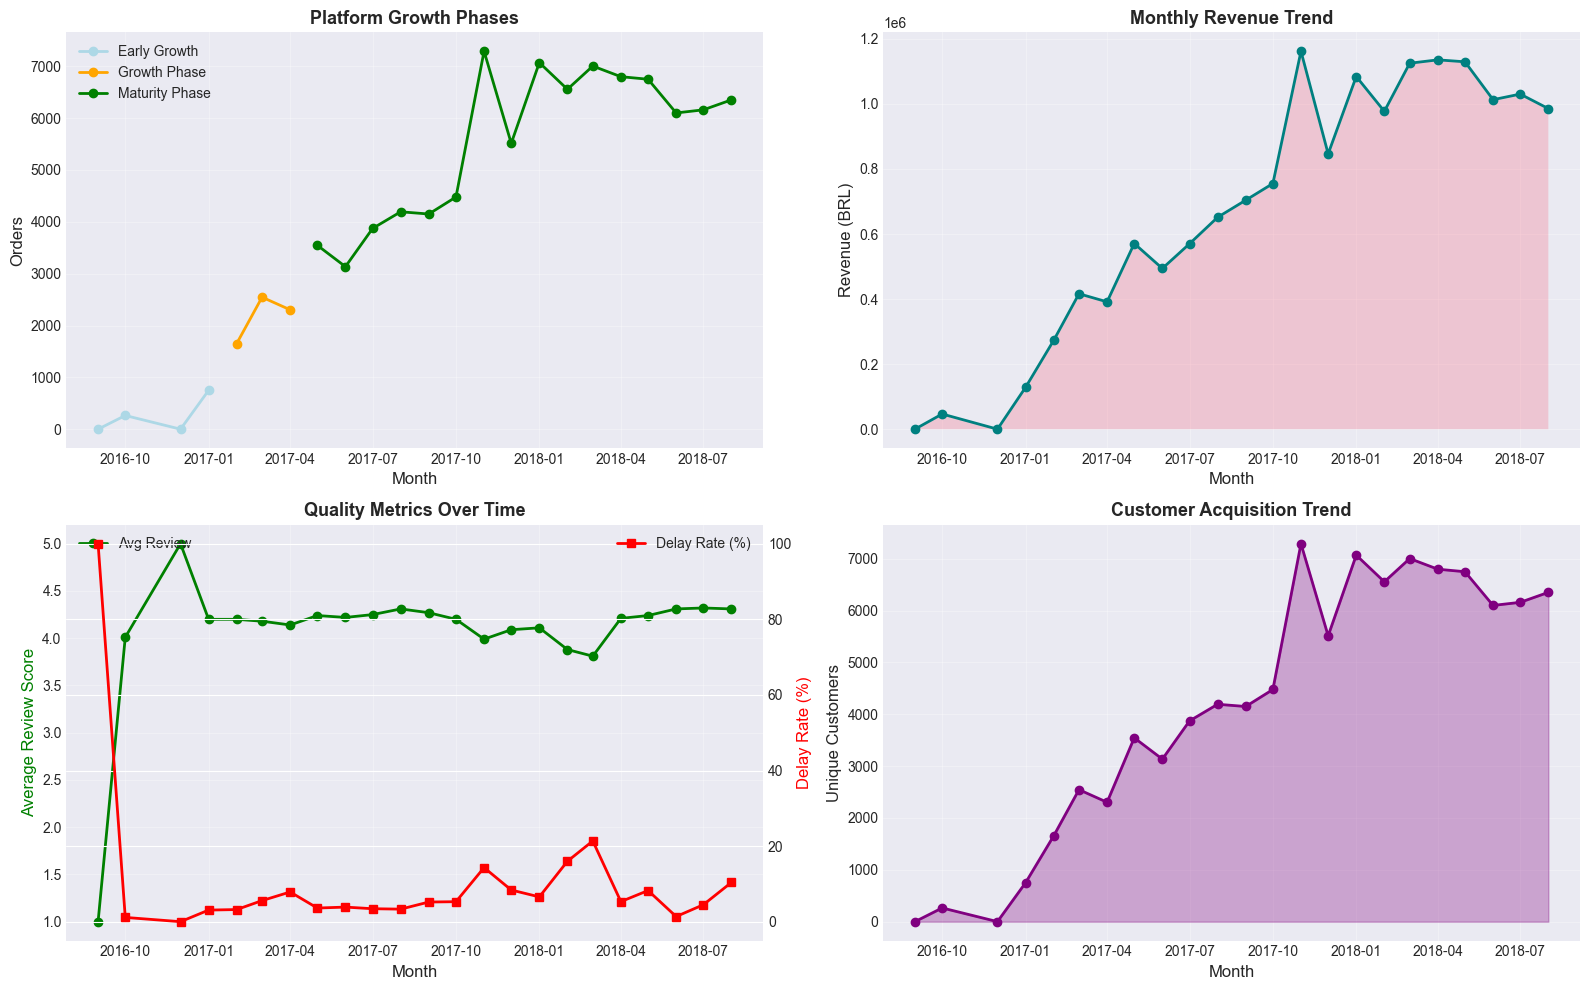

In [10]:
# Platform Phases based on Order Volume
def classify_phase(month, df):
    orders = df[df['month'] == month]['num_orders'].values[0]
    if orders < 1500:
        return 'Early Growth'
    elif orders < 3000:
        return 'Growth Phase'
    else:
        return 'Maturity Phase'
    
growth_df['phase'] = growth_df['month'].apply(lambda x: classify_phase(x, growth_df))

print("\nPlatform Phases:")
print(growth_df.groupby('phase').agg({
    'month': 'count', 
    'num_orders': ['min', 'max', 'mean'],
    'avg_review': 'mean',
    'delay_rate': 'mean'
}).round(2))


# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Orders over time with phases
colors = {'Early Growth': 'lightblue', 'Growth Phase': 'orange', 'Maturity Phase': 'green'}
for phase in ['Early Growth', 'Growth Phase', 'Maturity Phase']:
    phase_data = growth_df[growth_df['phase'] == phase]
    axes[0, 0].plot(phase_data['month'], phase_data['num_orders'], 
                   marker='o', linewidth=2, label=phase, color=colors[phase])

axes[0, 0].set_xlabel('Month', fontsize=12)
axes[0, 0].set_ylabel('Orders', fontsize=12)
axes[0, 0].set_title('Platform Growth Phases', fontsize=13, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Revenue growth
axes[0, 1].plot(growth_df['month'], growth_df['total_revenue'], 
               marker='o', linewidth=2, color='teal')
axes[0, 1].fill_between(growth_df['month'], growth_df['total_revenue'], alpha=0.3)
axes[0, 1].set_xlabel('Month', fontsize=12)
axes[0, 1].set_ylabel('Revenue (BRL)', fontsize=12)
axes[0, 1].set_title('Monthly Revenue Trend', fontsize=13, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Quality metrics over time
ax2 = axes[1, 0]
ax2_twin = ax2.twinx()
ax2.plot(growth_df['month'], growth_df['avg_review'], 
        marker='o', linewidth=2, color='green', label='Avg Review')
ax2_twin.plot(growth_df['month'], growth_df['delay_rate'], 
             marker='s', linewidth=2, color='red', label='Delay Rate (%)')
ax2.set_xlabel('Month', fontsize=12)
ax2.set_ylabel('Average Review Score', fontsize=12, color='green')
ax2_twin.set_ylabel('Delay Rate (%)', fontsize=12, color='red')
ax2.set_title('Quality Metrics Over Time', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend(loc='upper left')
ax2_twin.legend(loc='upper right')

# Customer acquisition
axes[1, 1].plot(growth_df['month'], growth_df['unique_customers'], 
               marker='o', linewidth=2, color='purple')
axes[1, 1].fill_between(growth_df['month'], growth_df['unique_customers'], alpha=0.3, color='purple')
axes[1, 1].set_xlabel('Month', fontsize=12)
axes[1, 1].set_ylabel('Unique Customers', fontsize=12)
axes[1, 1].set_title('Customer Acquisition Trend', fontsize=13, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/platform_maturity.png', dpi=300, bbox_inches='tight')
plt.show()



#### 1.2 Seasonality & Special Events

In [13]:
# Identify peak months
peak_months = growth_df.nlargest(3, 'num_orders')[['month', 'num_orders', 'total_revenue']]

print("Top 3 Peak Months:")
print(peak_months)


Top 3 Peak Months:
        month  num_orders  total_revenue
13 2017-11-01        7289     1161920.53
15 2018-01-01        7069     1084202.96
17 2018-03-01        7003     1125026.32


**Peak Month Hypothesis**

- 11/1/2017 - Guessing they might have had Thanksgiving offers
- 01/01/2018 - New Year Orders
- 03/01/2018 - Based on Google Search - Looks like its when Rio de Janeiro was established.  

Peak Months Detailed Analysis:
Total records: 2,056

----------------------------------------------------------------------
MONTH: 2017-11
----------------------------------------------------------------------

Top 5 Categories:
                 num_orders  total_revenue
category                                  
bed_bath_table          804       87957.63
sports_leisure          542       62686.24
furniture_decor         536       62091.27
health_beauty           519       78274.40
toys                    443       62611.26

Top 5 States:
                num_orders  total_revenue
customer_state                           
SP                    2919      350790.18
RJ                    1018      147782.40
MG                     932      132686.09
RS                     417       57463.27
PR                     367       45751.34

SP concentration: 39.7%


----------------------------------------------------------------------
MONTH: 2018-01
------------------------------------------------

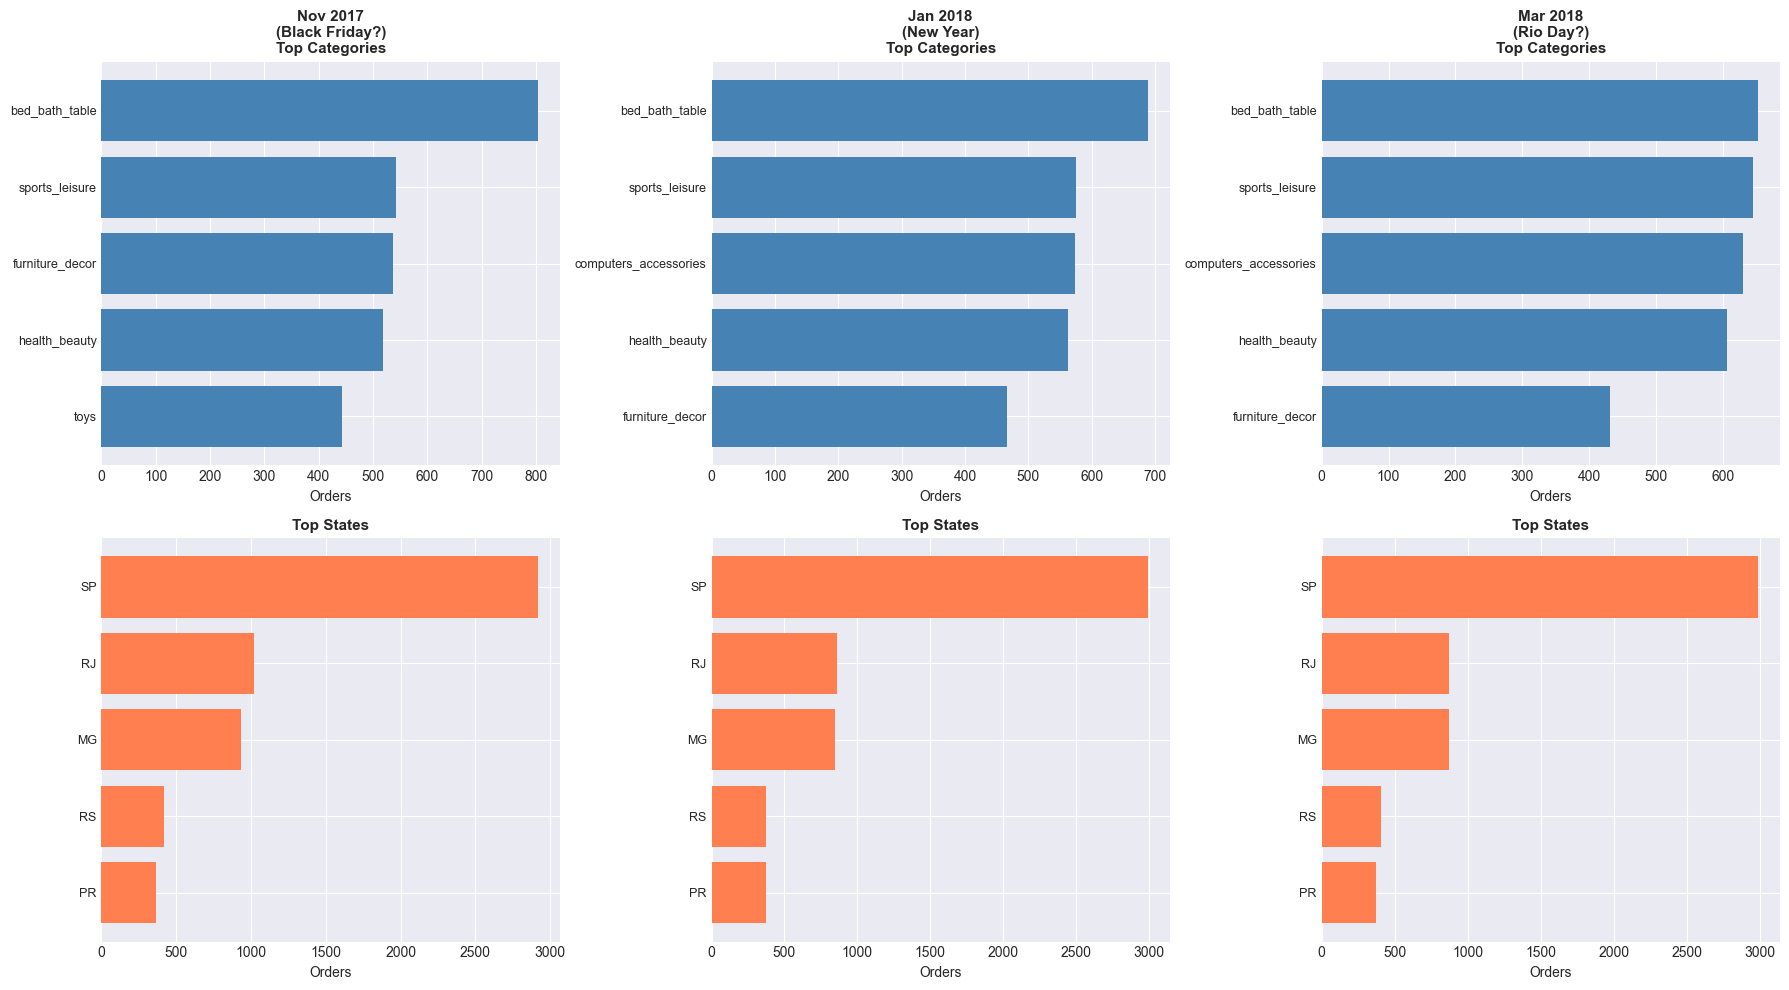

In [16]:
# Analyzing Peak Months in Detail - Products & Region

peak_months_query = """
SELECT 
    strftime('%Y-%m', o.order_purchase_timestamp) as month,
    COALESCE(pct.product_category_name_english, p.product_category_name, 'Unknown') as category,
    c.customer_state,
    COUNT(DISTINCT o.order_id) as num_orders,
    COUNT(oi.order_item_id) as num_items,
    ROUND(SUM(oi.price), 2) as total_revenue,
    ROUND(AVG(oi.price), 2) as avg_price
FROM orders o
JOIN customers c ON o.customer_id = c.customer_id
JOIN order_items oi ON o.order_id = oi.order_id
JOIN products p ON oi.product_id = p.product_id
LEFT JOIN product_category_name_translation pct 
    ON p.product_category_name = pct.product_category_name
WHERE o.order_status = 'delivered'
  AND strftime('%Y-%m', o.order_purchase_timestamp) IN ('2017-11', '2018-01', '2018-03')
GROUP BY month, category, c.customer_state
ORDER BY month, num_orders DESC
"""

peak_details = pd.read_sql(peak_months_query, conn)

print("Peak Months Detailed Analysis:")
print(f"Total records: {len(peak_details):,}\n")

# Analyzing each peak month
for month in ['2017-11', '2018-01', '2018-03']:
    month_data = peak_details[peak_details['month'] == month]
    
    print("-" * 70)
    print(f"MONTH: {month}")
    print("-" * 70)
    
    # Top 5 categories
    top_categories = month_data.groupby('category').agg({
        'num_orders': 'sum',
        'total_revenue': 'sum'
    }).nlargest(5, 'num_orders')
    
    print(f"\nTop 5 Categories:")
    print(top_categories)
    
    # Top 5 states
    top_states = month_data.groupby('customer_state').agg({
        'num_orders': 'sum',
        'total_revenue': 'sum'
    }).nlargest(5, 'num_orders')
    
    print(f"\nTop 5 States:")
    print(top_states)
    
    # Calculate what % of orders came from SP
    sp_pct = (month_data[month_data['customer_state'] == 'SP']['num_orders'].sum() / 
              month_data['num_orders'].sum() * 100)
    print(f"\nSP concentration: {sp_pct:.1f}%")
    print("\n")

# Visualizing peak month patterns
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

months = ['2017-11', '2018-01', '2018-03']
month_labels = ['Nov 2017\n(Black Friday?)', 'Jan 2018\n(New Year)', 'Mar 2018\n(Rio Day?)']

for idx, (month, label) in enumerate(zip(months, month_labels)):
    month_data = peak_details[peak_details['month'] == month]
    
    # Top categories
    top_cats = month_data.groupby('category')['num_orders'].sum().nlargest(5).sort_values()
    axes[0, idx].barh(top_cats.index, top_cats.values, color='steelblue')
    axes[0, idx].set_xlabel('Orders', fontsize=10)
    axes[0, idx].set_title(f'{label}\nTop Categories', fontsize=11, fontweight='bold')
    axes[0, idx].tick_params(axis='y', labelsize=9)
    
    # Top states
    top_states = month_data.groupby('customer_state')['num_orders'].sum().nlargest(5).sort_values()
    axes[1, idx].barh(top_states.index, top_states.values, color='coral')
    axes[1, idx].set_xlabel('Orders', fontsize=10)
    axes[1, idx].set_title(f'Top States', fontsize=11, fontweight='bold')
    axes[1, idx].tick_params(axis='y', labelsize=9)

plt.tight_layout()
plt.savefig('../reports/figures/peak_months_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


In [18]:
# Comparing Peak Month vs Average Month

print("PEAK MONTHS vs AVERAGE COMPARISON")


avg_month_query = """
SELECT 
    ROUND(AVG(monthly_orders), 2) as avg_monthly_orders,
    ROUND(AVG(monthly_revenue), 2) as avg_monthly_revenue
FROM (
    SELECT 
        strftime('%Y-%m', order_purchase_timestamp) as month,
        COUNT(*) as monthly_orders,
        SUM(total_order_value) as monthly_revenue
    FROM order_analysis
    WHERE order_status = 'delivered'
    GROUP BY month
)
"""

avg_stats = pd.read_sql(avg_month_query, conn)

print(f"\nAverage Month: {avg_stats['avg_monthly_orders'][0]:,.0f} orders")
print(f"\nPeak Months:")
print(f"  Nov 2017: 7,289 orders ({7289/avg_stats['avg_monthly_orders'][0]:.1f}x average)")
print(f"  Jan 2018: 7,069 orders ({7069/avg_stats['avg_monthly_orders'][0]:.1f}x average)")
print(f"  Mar 2018: 7,003 orders ({7003/avg_stats['avg_monthly_orders'][0]:.1f}x average)")

print("\nInsights:")
print("  • Nov 2017 is likely BLACK FRIDAY (big e-commerce event in Brazil)")
print("  • Jan 2018 could be post-holiday shopping + New Year sales")
print("  • Mar 2018 - check if there were any promotions or events")

PEAK MONTHS vs AVERAGE COMPARISON

Average Month: 4,195 orders

Peak Months:
  Nov 2017: 7,289 orders (1.7x average)
  Jan 2018: 7,069 orders (1.7x average)
  Mar 2018: 7,003 orders (1.7x average)

Insights:
  • Nov 2017 is likely BLACK FRIDAY (big e-commerce event in Brazil)
  • Jan 2018 could be post-holiday shopping + New Year sales
  • Mar 2018 - check if there were any promotions or events


In [19]:
print("*" * 70)
print("PEAK MONTH ANALYSIS - KEY FINDINGS")
print("*" * 70)

print("\nSURPRISING DISCOVERY:")
print("  • All 3 peak months show IDENTICAL category patterns")
print("  • bed_bath_table dominates in all cases")
print("  • No 'event-specific' shopping behavior detected")

print("\nWHAT THIS MEANS:")
print("  • Nov 2017 spike: Likely platform maturity + seasonal home shopping")
print("  • Jan 2018: Post-holiday home organization purchases")
print("  • Mar 2018: Continued growth trajectory")

print("\nBRAZILIAN E-COMMERCE INSIGHT:")
print("  • Home goods (bed/bath/furniture) are PRIMARY purchase drivers")
print("  • Unlike US Black Friday (electronics-heavy)")
print("  • Brazilian market shows strong home improvement focus")

print("\nGEOGRAPHIC CONSISTENCY:")
print("  • SP dominates regardless of event/month")
print("  • Same top 5 states in identical order")
print("  • Suggests structural market concentration, not event-driven")

print("\n" + "*" * 70)

**********************************************************************
PEAK MONTH ANALYSIS - KEY FINDINGS
**********************************************************************

SURPRISING DISCOVERY:
  • All 3 peak months show IDENTICAL category patterns
  • bed_bath_table dominates in all cases
  • No 'event-specific' shopping behavior detected

WHAT THIS MEANS:
  • Nov 2017 spike: Likely platform maturity + seasonal home shopping
  • Jan 2018: Post-holiday home organization purchases
  • Mar 2018: Continued growth trajectory

BRAZILIAN E-COMMERCE INSIGHT:
  • Home goods (bed/bath/furniture) are PRIMARY purchase drivers
  • Unlike US Black Friday (electronics-heavy)
  • Brazilian market shows strong home improvement focus

GEOGRAPHIC CONSISTENCY:
  • SP dominates regardless of event/month
  • Same top 5 states in identical order
  • Suggests structural market concentration, not event-driven

**********************************************************************


### 2. Premium vs Budget Order Dynamics

#### 2.1. Order Value Segmentation

In [22]:
# Order with values

value_query = """
SELECT
    total_order_value,
    review_score,
    is_delayed,
    delivery_delay_days,
    actual_delivery_days,
    customer_state,
    num_items
FROM order_analysis
WHERE order_status = 'delivered'
    AND total_order_value IS NOT NULL
    AND review_score IS NOT NULL
"""

value_df = pd.read_sql(value_query, conn)

# Value Segmentation
value_df['value_segment'] = pd.cut(value_df['total_order_value'],
                                   bins=[0,50,100,200,500, float('inf')],
                                   labels=['Budget(<50)', 'Low(50-100)', 
                                           'Medium(100-200)', 'High(200-500)', 
                                           'Premium(500+)'])
print(f"Total Orders Analyzed: {len(value_df):,}")
print("\nValue Segment Distribution:")
print(value_df['value_segment'].value_counts().sort_index())

# Segment Comparison
segment_comparison = value_df.groupby('value_segment').agg({
    'total_order_value': ['count','mean', 'median', 'sum'],
    'review_score': 'mean',
    'is_delayed': lambda x: (x.sum() / len(x) * 100),
    'delivery_delay_days': 'mean',
    'num_items': 'mean'
}).round(2)
segment_comparison.columns = ['Order_Count', 'Avg_Order_Value', 'Median_Order_Value', 'Total_Revenue',
                              'Avg_Review_Score', 'Delay_Rate_%', 'Avg_Delay_Days', 'Avg_Num_Items']
print("\nSegment Comparison:")
print(segment_comparison)

Total Orders Analyzed: 95,832

Value Segment Distribution:
value_segment
Budget(<50)        16327
Low(50-100)        29149
Medium(100-200)    30841
High(200-500)      15438
Premium(500+)       4077
Name: count, dtype: int64

Segment Comparison:
                 Order_Count  Avg_Order_Value  Median_Order_Value  \
value_segment                                                       
Budget(<50)            16327            36.91               37.54   
Low(50-100)            29149            73.33               72.18   
Medium(100-200)        30841           142.03              138.53   
High(200-500)          15438           290.01              267.43   
Premium(500+)           4077           923.16              737.36   

                 Total_Revenue  Avg_Review_Score  Delay_Rate_%  \
value_segment                                                    
Budget(<50)          602599.28              4.25          6.98   
Low(50-100)         2137381.55              4.19          7.80   
Medium(

#### 2.2 Premium Customer - Faster Delivery?

Premium (500+) vs Budget (<100) Comparison:

Premium Orders:
  Count: 4,077
  Delay Rate: 9.32%
  Avg Review: 3.99

Budget Orders:
  Count: 45,473
  Delay Rate: 7.50%
  Avg Review: 4.21

Statistical Test: t=4.188, p=0.0000
Statistically significant difference. Premium orders are more likely to be delayed than budget orders.


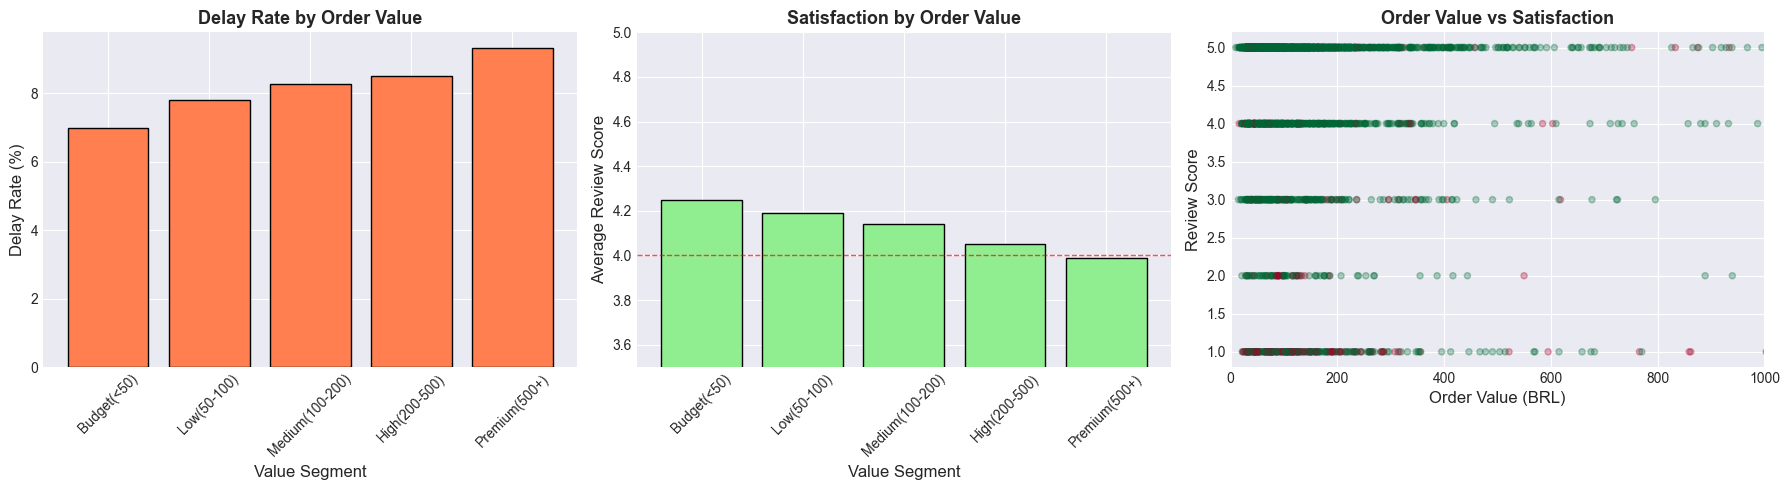

In [26]:
# Does Higher Value = Better Experience?
premium = value_df[value_df['total_order_value'] >= 500]
budget = value_df[value_df['total_order_value'] < 100]

print("Premium (500+) vs Budget (<100) Comparison:")
print(f"\nPremium Orders:")
print(f"  Count: {len(premium):,}")
print(f"  Delay Rate: {premium['is_delayed'].mean() * 100:.2f}%")
print(f"  Avg Review: {premium['review_score'].mean():.2f}")

print(f"\nBudget Orders:")
print(f"  Count: {len(budget):,}")
print(f"  Delay Rate: {budget['is_delayed'].mean() * 100:.2f}%")
print(f"  Avg Review: {budget['review_score'].mean():.2f}")

# T-test
t_stat, p_value = stats.ttest_ind(premium['is_delayed'], budget['is_delayed'])
print(f"\nStatistical Test: t={t_stat:.3f}, p={p_value:.4f}")
if p_value < 0.05:
    print("Statistically significant difference. Premium orders are more likely to be delayed than budget orders.")
else:
    print("No significant difference")


# Visualization

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Delay rates by segment
axes[0].bar(segment_comparison.index, segment_comparison['Delay_Rate_%'], 
           color='coral', edgecolor='black')
axes[0].set_xlabel('Value Segment', fontsize=12)
axes[0].set_ylabel('Delay Rate (%)', fontsize=12)
axes[0].set_title('Delay Rate by Order Value', fontsize=13, fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)

# Review scores by segment
axes[1].bar(segment_comparison.index, segment_comparison['Avg_Review_Score'], 
           color='lightgreen', edgecolor='black')
axes[1].axhline(4.0, color='red', linestyle='--', linewidth=1, alpha=0.7)
axes[1].set_xlabel('Value Segment', fontsize=12)
axes[1].set_ylabel('Average Review Score', fontsize=12)
axes[1].set_title('Satisfaction by Order Value', fontsize=13, fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)
axes[1].set_ylim(3.5, 5.0)

# Scatter: value vs review
sample = value_df.sample(min(3000, len(value_df)), random_state=42)
axes[2].scatter(sample['total_order_value'], sample['review_score'], 
               alpha=0.3, s=20, c=sample['is_delayed'], cmap='RdYlGn_r')
axes[2].set_xlabel('Order Value (BRL)', fontsize=12)
axes[2].set_ylabel('Review Score', fontsize=12)
axes[2].set_title('Order Value vs Satisfaction', fontsize=13, fontweight='bold')
axes[2].set_xlim(0, 1000)

plt.tight_layout()
plt.savefig('../reports/figures/premium_vs_budget.png', dpi=300, bbox_inches='tight')
plt.show()


### 3. Category Deep Dive

#### 3.1 Why health_beauty Dominates?

In [28]:
# Top Category Analysis
cat_query = """
SELECT 
    COALESCE(pct.product_category_name_english, p.product_category_name, 'Unknown') as category,
    COUNT(DISTINCT oi.order_id) as num_orders,
    COUNT(*) as num_items,
    ROUND(AVG(oi.price), 2) as avg_price,
    ROUND(SUM(oi.price), 2) as total_revenue,
    ROUND(AVG(r.review_score), 2) as avg_review_score,
    ROUND(AVG(JULIANDAY(o.order_delivered_customer_date) - JULIANDAY(o.order_estimated_delivery_date)), 2) as avg_delay,
    ROUND(SUM(CASE WHEN JULIANDAY(o.order_delivered_customer_date) > JULIANDAY(o.order_estimated_delivery_date) THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 2) as delay_rate
FROM order_items oi
JOIN products p ON oi.product_id = p.product_id
LEFT JOIN product_category_name_translation pct ON p.product_category_name = pct.product_category_name
JOIN orders o ON oi.order_id = o.order_id
LEFT JOIN order_reviews r ON o.order_id = r.order_id
WHERE o.order_status = 'delivered'
  AND o.order_delivered_customer_date IS NOT NULL
GROUP BY category
HAVING num_orders >= 100
ORDER BY total_revenue DESC
LIMIT 20
"""

cat_df = pd.read_sql(cat_query, conn)

print("Top 20 Categories by Revenue:")
cat_df

Top 20 Categories by Revenue:


,category,num_orders,num_items,avg_price,total_revenue,avg_review_score,avg_delay,delay_rate
0,health_beauty,8647,9519,130.00,1237439.95,4.19,-11.27,9.06
1,watches_gifts,5493,5867,198.90,1166968.63,4.07,-11.22,8.28
2,bed_bath_table,9272,11107,93.38,1037177.69,3.92,-10.96,8.40
3,sports_leisure,7529,8488,113.10,960010.09,4.17,-11.35,7.38
4,computers_accessories,6529,7707,116.28,896132.29,3.99,-11.74,7.75
5,furniture_decor,6307,8239,87.19,718344.78,3.95,-11.74,8.37
6,housewares,5743,6819,90.61,617836.73,4.11,-11.63,6.47
7,cool_stuff,3559,3727,164.23,612071.86,4.19,-11.80,6.76
8,auto,3809,4157,139.56,580146.14,4.12,-10.73,8.28
9,toys,3803,4037,116.90,471920.79,4.21,-11.37,7.48


In [34]:
# Health_Beauty category analysis

hb = cat_df[cat_df['category'] == 'health_beauty']

print("\nhealth_beauty Category Breakdown:")
print(f"  Total Orders: {hb['num_orders'].values[0]:,}")
print(f"  Total Revenue: BRL {hb['total_revenue'].values[0]:,.2f}")
print(f"  Avg Price: BRL {hb['avg_price'].values[0]:.2f}")
print(f"  Avg Review: {hb['avg_review_score'].values[0]:.2f} Stars")
print(f"  Delay Rate: {hb['delay_rate'].values[0]:.2f}%")

# Compare to overall averages
overall_avg = cat_df.agg({
    'avg_price': 'mean',
    'avg_review_score': 'mean',
    'delay_rate': 'mean'
})

print("\n health_beauty vs Category Averages:")
print(f"  Price: BRL {hb['avg_price'].values[0]:.2f} vs BRL {overall_avg['avg_price']:.2f} (avg)")
print(f"  Review: {hb['avg_review_score'].values[0]:.2f} vs {overall_avg['avg_review_score']:.2f} (avg)")
print(f"  Delay Rate: {hb['delay_rate'].values[0]:.2f}% vs {overall_avg['delay_rate']:.2f}% (avg)")


health_beauty Category Breakdown:
  Total Orders: 8,647
  Total Revenue: BRL 1,237,439.95
  Avg Price: BRL 130.00
  Avg Review: 4.19 Stars
  Delay Rate: 9.06%

 health_beauty vs Category Averages:
  Price: BRL 130.00 vs BRL 185.06 (avg)
  Review: 4.19 vs 4.10 (avg)
  Delay Rate: 9.06% vs 7.74% (avg)


##### Health_Beauty vs Category Averages:
  - Price: BRL 130.00 vs BRL 185.06 (avg) → 29.7% CHEAPER 
  - Review: 4.19 vs 4.10 (avg) → +0.09 stars 
  - Delay Rate: 9.06% vs 7.74% (avg) → +1.32% WORSE 

##### INSIGHT - WHY health_beauty STILL DOMINATES:

1. PRICE ADVANTAGE (29.7% cheaper than average):
   - Lower barrier to purchase
   - Accessible to wider customer base
   - Encourages repeat purchases

2. ABOVE-AVERAGE SATISFACTION (despite slightly more delays):
   - 4.19 vs 4.10 average
   - Customers are MORE FORGIVING of delays in this category
   - Why? Consumables aren't urgent (can wait a few extra days)

3. THE REAL SECRET - CUSTOMER EXPECTATIONS:
   - health_beauty = Low urgency items
   - Shampoo, cosmetics, vitamins = Not time-sensitive
   - Unlike electronics or gifts (high urgency)
   - Delays hurt less when expectations are lower

4. REPEAT PURCHASE ECONOMICS:
   - Lower price → Lower risk
   - Consumable → Need to reorder
   - Good enough experience → Come back

##### KEY BUSINESS INSIGHT:
   **health_beauty** succeeds NOT by being the best at delivery, but by having the RIGHT combination of:
   - Affordable pricing (low risk)
   - Low urgency (forgiving customers)
   - Repeat purchase nature (locked-in demand)
   - Good enough satisfaction (4.19 is solid)

##### IMPLICATION:
- Categories with HIGHER urgency (electronics, gifts, events) will suffer MORE from the same delay rate!
- **Need to investigate delay sensitivity BY CATEGORY**

#### 3.2 Delay Sensitivity by Category

DELAY SENSITIVITY BY CATEGORY

MOST DELAY-TOLERANT Categories (high reviews despite delays):
             category  avg_review_score  delay_rate  delay_tolerance
     small_appliances              4.23        5.89         0.613933
             pet_shop              4.22        6.13         0.591865
            computers              4.22        6.53         0.560425
           housewares              4.11        6.47         0.550201
           cool_stuff              4.19        6.76         0.539948
            perfumery              4.22        7.33         0.506603
       sports_leisure              4.17        7.38         0.497613
                 toys              4.21        7.48         0.496462
           stationery              4.24        8.08         0.466960
computers_accessories              3.99        7.75         0.456000


LEAST DELAY-TOLERANT Categories (reviews suffer badly from delays):
           category  avg_review_score  delay_rate  delay_tolerance
   office_f

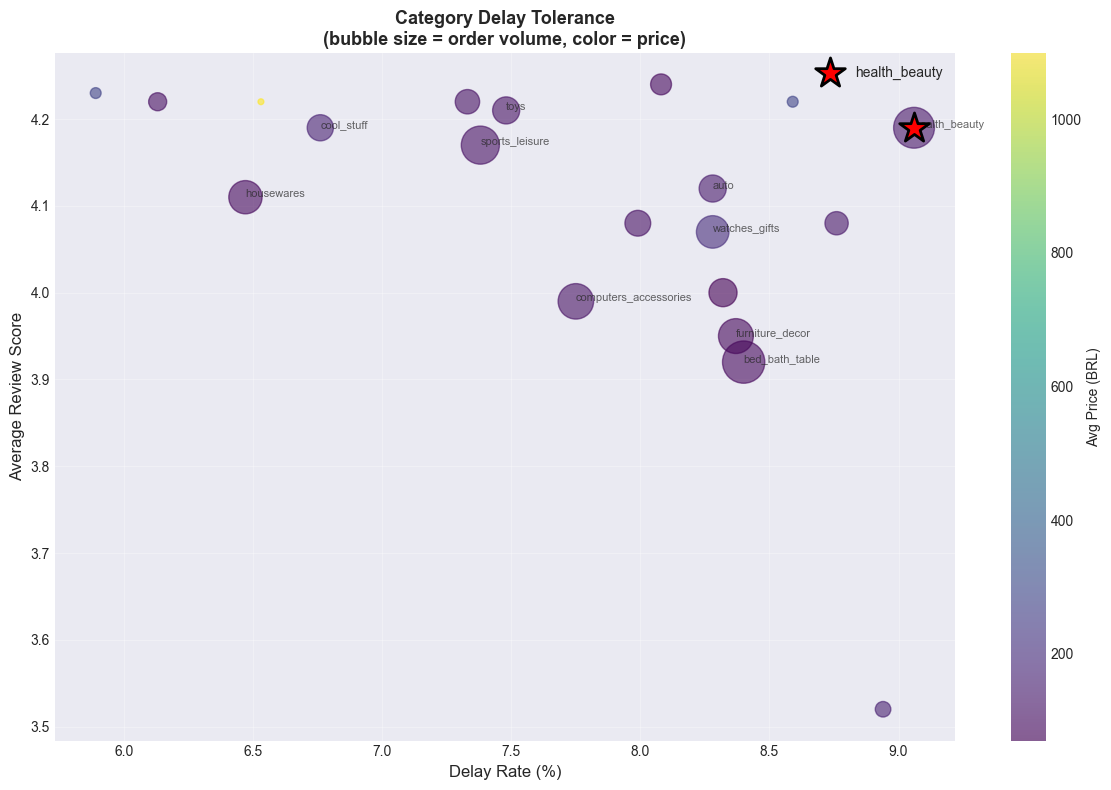

In [39]:
# Which categories are most/least tolerant of delays?
print("DELAY SENSITIVITY BY CATEGORY")
# "efficiency score" = review_score / (delay_rate + 1) Higher score = better satisfaction despite delays
cat_df['delay_tolerance'] = cat_df['avg_review_score'] / (cat_df['delay_rate'] + 1)

print("\nMOST DELAY-TOLERANT Categories (high reviews despite delays):")
tolerant = cat_df.nlargest(10, 'delay_tolerance')[['category', 'avg_review_score', 'delay_rate', 'delay_tolerance']]
print(tolerant.to_string(index=False))

print("\n\nLEAST DELAY-TOLERANT Categories (reviews suffer badly from delays):")
intolerant = cat_df.nsmallest(10, 'delay_tolerance')[['category', 'avg_review_score', 'delay_rate', 'delay_tolerance']]
print(intolerant.to_string(index=False))


# Visualize delay tolerance

# Scatter plot
fig, ax = plt.subplots(figsize=(12, 8))

scatter = ax.scatter(cat_df['delay_rate'], 
                     cat_df['avg_review_score'],
                     s=cat_df['num_orders']/10,
                     alpha=0.6,
                     c=cat_df['avg_price'],
                     cmap='viridis')

# Highlight health_beauty
hb_row = cat_df[cat_df['category'] == 'health_beauty']
ax.scatter(hb_row['delay_rate'], hb_row['avg_review_score'],
          s=500, color='red', marker='*', edgecolors='black', linewidth=2,
          label='health_beauty', zorder=5)

# Add labels for interesting categories
for idx, row in cat_df.head(10).iterrows():
    ax.annotate(row['category'], 
               (row['delay_rate'], row['avg_review_score']),
               fontsize=8, alpha=0.7)

ax.set_xlabel('Delay Rate (%)', fontsize=12)
ax.set_ylabel('Average Review Score', fontsize=12)
ax.set_title('Category Delay Tolerance\n(bubble size = order volume, color = price)', 
            fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend()

plt.colorbar(scatter, ax=ax, label='Avg Price (BRL)')
plt.tight_layout()
plt.savefig('../reports/figures/category_delay_tolerance.png', dpi=300, bbox_inches='tight')
plt.show()

**HYPOTHESIS:**
- Low urgency items (health/beauty, home goods) = More tolerant
- High urgency items (gifts, events, electronics) = Less tolerant
- To test: Compare delay impact on reviews by category in [Diagnostic Analytics](04_diagnostic_analytics.ipynb)

#### 3.3 Category Performance Mix


Category Performance Quadrants:
quadrant
Cash Cows (High Rev, Low Sat)    6
Niche (Low Rev, High Sat)        6
Problem (Low Rev, Low Sat)       4
Stars (High Rev, High Sat)       4
Name: category, dtype: int64


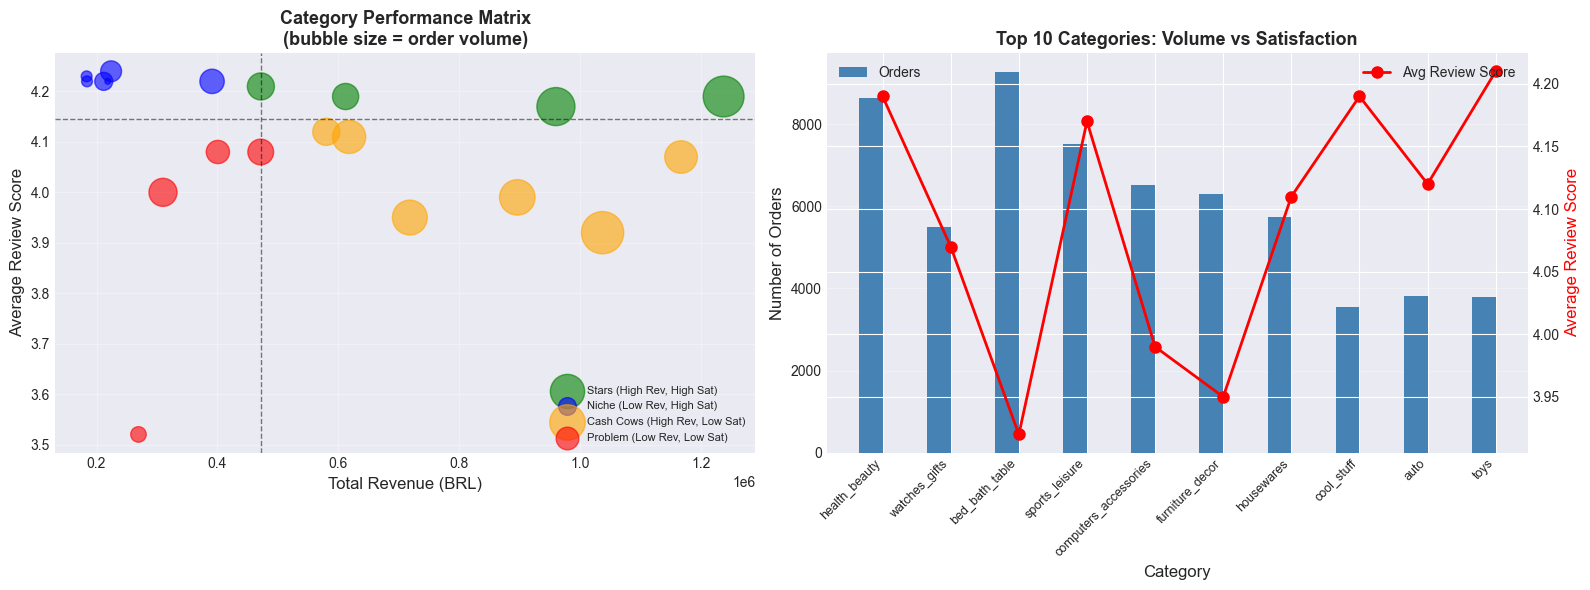

In [ ]:
# Quadrant Analysis: Revenue vs Satisfaction
median_review = cat_df['avg_review_score'].median()
median_revenue = cat_df['total_revenue'].median()

def classify_category(row):
    if row['avg_review_score'] >= median_review and row['total_revenue'] >= median_revenue:
        return 'Stars (High Rev, High Sat)'
    elif row['avg_review_score'] >= median_review and row['total_revenue'] < median_revenue:
        return 'Niche (Low Rev, High Sat)'
    elif row['avg_review_score'] < median_review and row['total_revenue'] >= median_revenue:
        return 'Cash Cows (High Rev, Low Sat)'
    else:
        return 'Problem (Low Rev, Low Sat)'

cat_df['quadrant'] = cat_df.apply(classify_category, axis=1)

print("\nCategory Performance Quadrants:")
print(cat_df.groupby('quadrant')['category'].count())


# Visualize quadrants
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Revenue vs satisfaction scatter
colors_map = {
    'Stars (High Rev, High Sat)': 'green',
    'Niche (Low Rev, High Sat)': 'blue',
    'Cash Cows (High Rev, Low Sat)': 'orange',
    'Problem (Low Rev, Low Sat)': 'red'
}

for quadrant, color in colors_map.items():
    data = cat_df[cat_df['quadrant'] == quadrant]
    axes[0].scatter(data['total_revenue'], data['avg_review_score'], 
                   s=data['num_orders']/10, alpha=0.6, color=color, label=quadrant)

axes[0].axhline(median_review, color='black', linestyle='--', linewidth=1, alpha=0.5)
axes[0].axvline(median_revenue, color='black', linestyle='--', linewidth=1, alpha=0.5)
axes[0].set_xlabel('Total Revenue (BRL)', fontsize=12)
axes[0].set_ylabel('Average Review Score', fontsize=12)
axes[0].set_title('Category Performance Matrix\n(bubble size = order volume)', 
                 fontsize=13, fontweight='bold')
axes[0].legend(fontsize=8)
axes[0].grid(True, alpha=0.3)

# Top 10 categories comparison
top_10 = cat_df.head(10)
x = np.arange(len(top_10))
width = 0.35

ax2 = axes[1]
ax2_twin = ax2.twinx()

ax2.bar(x - width/2, top_10['num_orders'], width, label='Orders', color='steelblue')
ax2_twin.plot(x, top_10['avg_review_score'], 'ro-', linewidth=2, markersize=8, label='Avg Review Score')

ax2.set_xlabel('Category', fontsize=12)
ax2.set_ylabel('Number of Orders', fontsize=12)
ax2_twin.set_ylabel('Average Review Score', fontsize=12, color='red')
ax2.set_title('Top 10 Categories: Volume vs Satisfaction', fontsize=13, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(top_10['category'], rotation=45, ha='right', fontsize=9)
ax2.legend(loc='upper left')
ax2_twin.legend(loc='upper right')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../reports/figures/category_performance.png', dpi=300, bbox_inches='tight')
plt.show()

#### 3.4 Delay Sensitive Categories

In [43]:
# Delay Sensitivity by Category - Key Findings
print("Categories Most Impacted by Delays (highest delay rates):")
print(cat_df.nlargest(10, 'delay_rate')[['category', 'delay_rate', 'avg_review_score', 'num_orders']])

print("\nCategories Least Impacted (lowest delay rates):")
print(cat_df.nsmallest(10, 'delay_rate')[['category', 'delay_rate', 'avg_review_score', 'num_orders']])

Categories Most Impacted by Delays (highest delay rates):
               category  delay_rate  avg_review_score  num_orders
0         health_beauty        9.06              4.19        8647
14     office_furniture        8.94              3.52        1254
11                 baby        8.76              4.08        2809
18  musical_instruments        8.59              4.22         611
2        bed_bath_table        8.40              3.92        9272
5       furniture_decor        8.37              3.95        6307
13            telephony        8.32              4.00        4093
1         watches_gifts        8.28              4.07        5493
8                  auto        8.28              4.12        3809
15           stationery        8.08              4.24        2264

Categories Least Impacted (lowest delay rates):
                 category  delay_rate  avg_review_score  num_orders
19       small_appliances        5.89              4.23         609
17               pet_shop      

### 4. Urban vs Rural

#### 4.1 Geo Concentration

In [54]:
# State Perf Details
state_query = """
SELECT 
    customer_state,
    COUNT(*) as num_orders,
    COUNT(DISTINCT customer_id) as unique_customers,
    ROUND(AVG(total_order_value), 2) as avg_order_value,
    ROUND(SUM(total_order_value), 2) as total_revenue,
    ROUND(AVG(review_score), 2) as avg_review_score,
    ROUND(AVG(actual_delivery_days), 2) as avg_delivery_days,
    ROUND(AVG(delivery_delay_days), 2) as avg_delay_days,
    ROUND(SUM(is_delayed) * 100.0 / COUNT(*), 2) as delay_rate
FROM order_analysis
WHERE order_status = 'delivered'
  AND customer_state IS NOT NULL
GROUP BY customer_state
HAVING num_orders >= 50
ORDER BY num_orders DESC
"""

state_df = pd.read_sql(state_query, conn)

# Calculate market concentration
state_df['cumulative_pct'] = (state_df['num_orders'].cumsum() / state_df['num_orders'].sum() * 100).round(2)

print("State Market Concentration:")
print(state_df[['customer_state', 'num_orders', 'cumulative_pct']].head(10))

# Top 3 states account for what % of business?
top3_pct = state_df.head(3)['cumulative_pct'].iloc[-1]
print(f"\n Top 3 states {list(state_df.head(3)['customer_state'])} = {top3_pct:.1f}% of all orders!")

State Market Concentration:
  customer_state  num_orders  cumulative_pct
0             SP       40501           42.00
1             RJ       12350           54.80
2             MG       11354           66.58
3             RS        5345           72.12
4             PR        4923           77.22
5             SC        3546           80.90
6             BA        3256           84.28
7             DF        2080           86.43
8             ES        1995           88.50
9             GO        1957           90.53

 Top 3 states ['SP', 'RJ', 'MG'] = 66.6% of all orders!



Urban vs Rural Performance:
               Total_Orders  Avg_Review  Avg_Delivery_Days  Delay_Rate_%  \
region_type                                                                
1.Major Urban         69550        4.14              12.84          8.03   
2.Urban               20629        4.08              16.30         10.30   
3.Rural                6258        4.07              21.14         11.09   

               Num_States  
region_type                
1.Major Urban           4  
2.Urban                 8  
3.Rural                14  


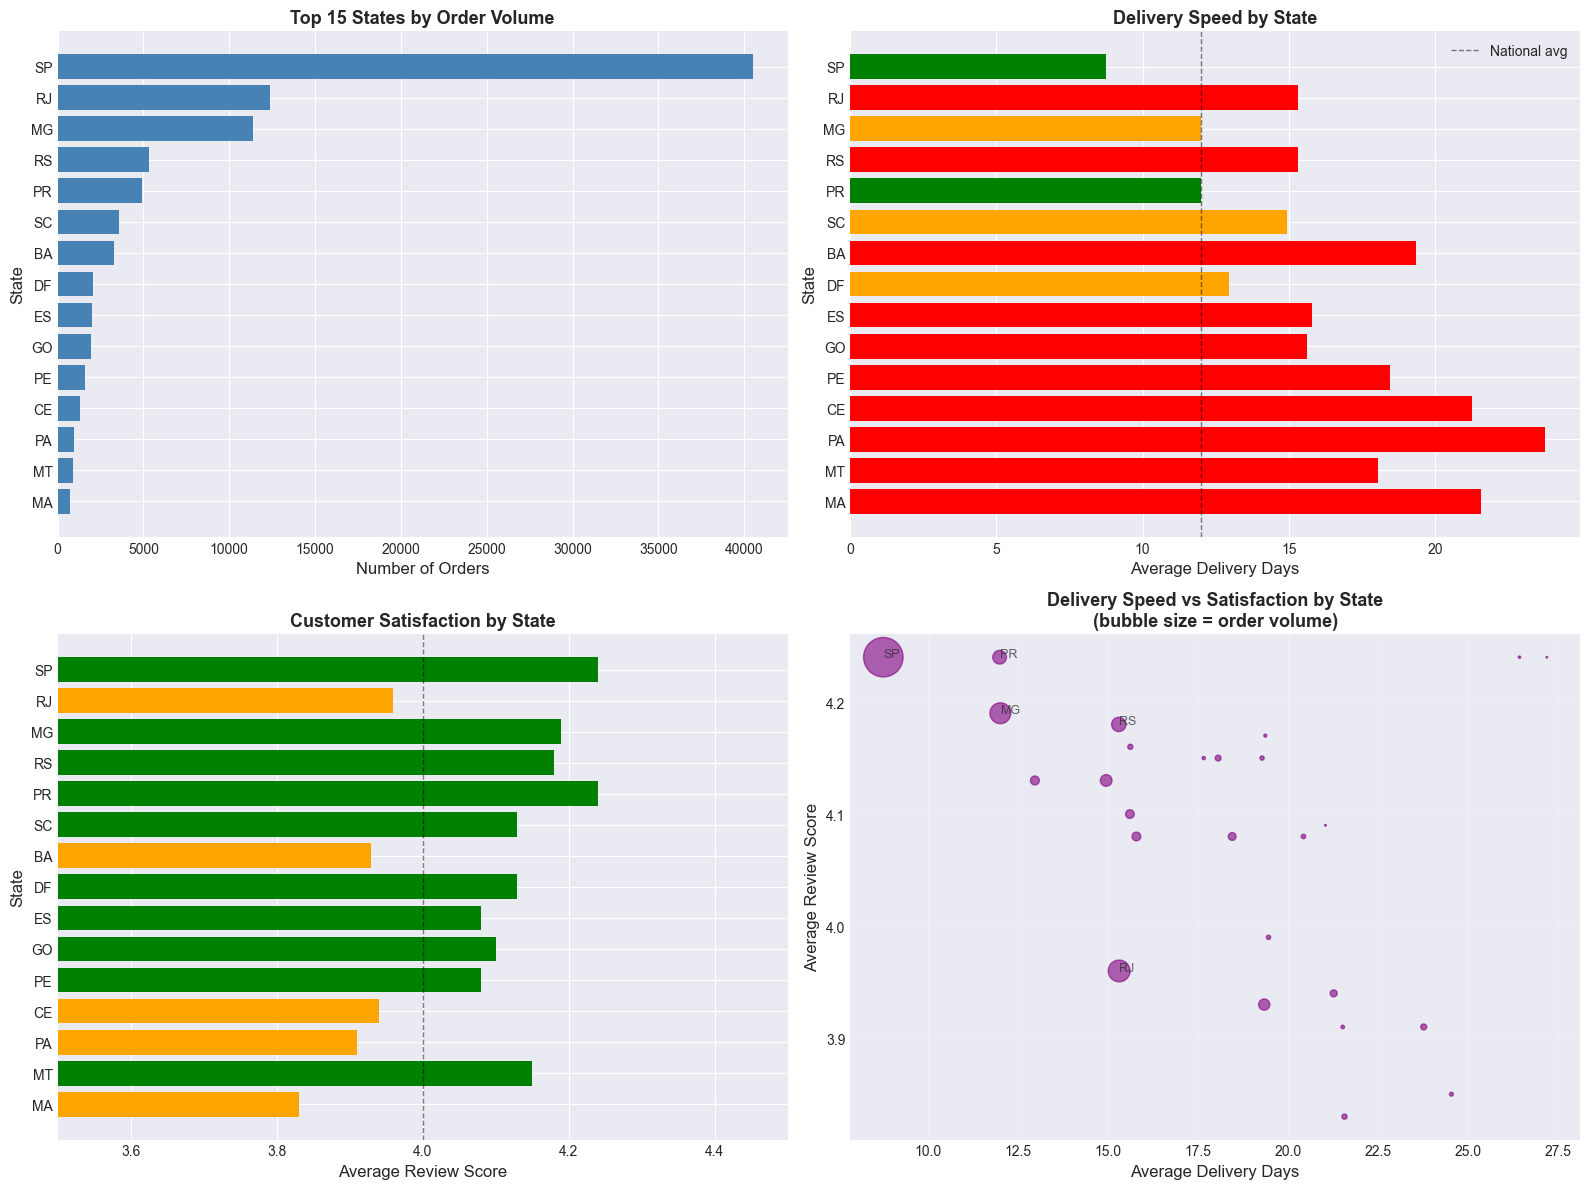

In [59]:
# State Classification as Urban vs Rural based on Order Volume
state_df['region_type'] = state_df['num_orders'].apply(
    lambda x: '1.Major Urban' if x >= 5000 else '2.Urban' if x >= 1000 else '3.Rural'
)

region_comparison = state_df.groupby('region_type').agg({
    'num_orders': 'sum',
    'avg_review_score': 'mean',
    'avg_delivery_days': 'mean',
    'delay_rate': 'mean',
    'customer_state': 'count'
}).round(2)

region_comparison.columns = ['Total_Orders', 'Avg_Review', 'Avg_Delivery_Days', 'Delay_Rate_%', 'Num_States']

print("\nUrban vs Rural Performance:")
print(region_comparison)

# Visualize state performance

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Top states by volume
top_15 = state_df.head(15)
axes[0, 0].barh(top_15['customer_state'], top_15['num_orders'], color='steelblue')
axes[0, 0].set_xlabel('Number of Orders', fontsize=12)
axes[0, 0].set_ylabel('State', fontsize=12)
axes[0, 0].set_title('Top 15 States by Order Volume', fontsize=13, fontweight='bold')
axes[0, 0].invert_yaxis()

# Delivery days by state
colors = ['green' if x <= 12 else 'orange' if x <= 15 else 'red' 
          for x in top_15['avg_delivery_days']]
axes[0, 1].barh(top_15['customer_state'], top_15['avg_delivery_days'], color=colors)
axes[0, 1].axvline(12, color='black', linestyle='--', linewidth=1, alpha=0.5, label='National avg')
axes[0, 1].set_xlabel('Average Delivery Days', fontsize=12)
axes[0, 1].set_ylabel('State', fontsize=12)
axes[0, 1].set_title('Delivery Speed by State', fontsize=13, fontweight='bold')
axes[0, 1].invert_yaxis()
axes[0, 1].legend()

# Review scores by state
colors_review = ['green' if x >= 4.0 else 'orange' if x >= 3.5 else 'red' 
                for x in top_15['avg_review_score']]
axes[1, 0].barh(top_15['customer_state'], top_15['avg_review_score'], color=colors_review)
axes[1, 0].axvline(4.0, color='black', linestyle='--', linewidth=1, alpha=0.5)
axes[1, 0].set_xlabel('Average Review Score', fontsize=12)
axes[1, 0].set_ylabel('State', fontsize=12)
axes[1, 0].set_title('Customer Satisfaction by State', fontsize=13, fontweight='bold')
axes[1, 0].invert_yaxis()
axes[1, 0].set_xlim(3.5, 4.5)

# Delivery vs satisfaction scatter
axes[1, 1].scatter(state_df['avg_delivery_days'], state_df['avg_review_score'], 
                  s=state_df['num_orders']/50, alpha=0.6, color='purple')
axes[1, 1].set_xlabel('Average Delivery Days', fontsize=12)
axes[1, 1].set_ylabel('Average Review Score', fontsize=12)
axes[1, 1].set_title('Delivery Speed vs Satisfaction by State\n(bubble size = order volume)', 
                    fontsize=13, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

# Annotate major states
for idx, row in state_df.head(5).iterrows():
    axes[1, 1].annotate(row['customer_state'], 
                       (row['avg_delivery_days'], row['avg_review_score']),
                       fontsize=9, alpha=0.7)

plt.tight_layout()
plt.savefig('../reports/figures/geographic_deep_dive.png', dpi=300, bbox_inches='tight')
plt.show()

### 5. Delay Impact Analysis

#### 5.1 Delay Threshold Analysis

Total orders analyzed: 93,407

Review Score by Delay Threshold:
                      Avg_Review  Count  Avg_Order_Value
delay_bucket                                            
Early (>5d)                 4.31  77010           159.66
Slightly Early (<5d)        4.15   8811           147.15
On-time                     4.00      5           187.97
Late (1-5d)                 3.46   3568           159.55
Late (5-10d)                1.89   1861           182.13
Late (10-15d)               1.66    897           181.55
Very Late (15d+)            1.65   1255           181.89

Key Insight:
  • Early (>5d):      4.31 stars
  • Slightly Early:   4.15 stars
  • On-time:          4.00 stars
  • 1-5 days late:    3.46 stars (Noticeable drop)
  • 5-10 days late:   1.89 stars
  • 10-15 days late:  1.66 stars
  • 15+ days late:    1.65 stars (SEVERE IMPACT)

Critical Finding: Ratings drop by 0.54 points as soon as a package is even 1 day late.


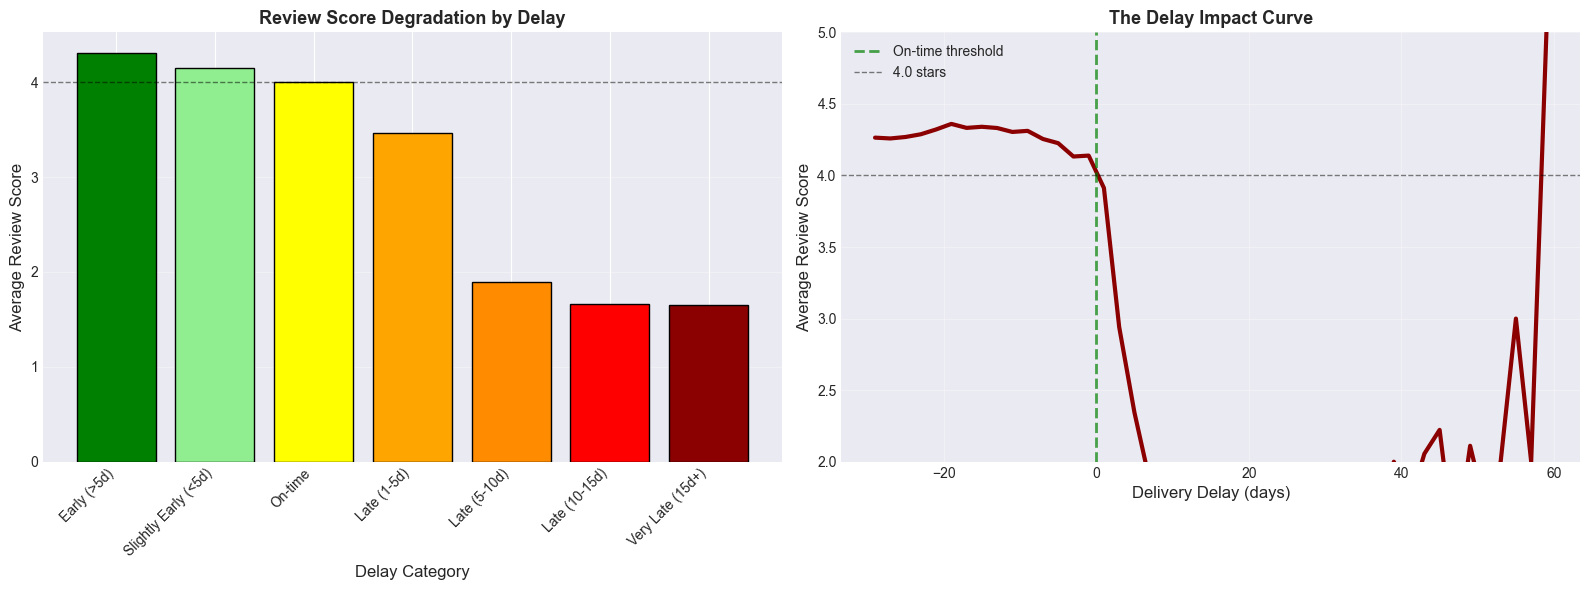

In [67]:
# Get Delivery Data
delay_impact_query = """
SELECT 
    delivery_delay_days,
    review_score,
    total_order_value,
    customer_state
FROM order_analysis
WHERE order_status = 'delivered'
  AND delivery_delay_days IS NOT NULL
  AND review_score IS NOT NULL
  AND delivery_delay_days BETWEEN -30 AND 60
"""

delay_impact = pd.read_sql(delay_impact_query, conn)

# Create delay buckets
delay_impact['delay_bucket'] = pd.cut(
    delay_impact['delivery_delay_days'],
    bins=[-float('inf'), -5, -0.001, 0, 5, 10, 15, float('inf')],
    labels=[
        'Early (>5d)', 
        'Slightly Early (<5d)', 
        'On-time', 
        'Late (1-5d)', 
        'Late (5-10d)', 
        'Late (10-15d)', 
        'Very Late (15d+)'
    ]
)

print(f"Total orders analyzed: {len(delay_impact):,}")

# Analyze review scores by delay bucket
bucket_analysis = delay_impact.groupby('delay_bucket').agg({
    'review_score': ['mean', 'count'],
    'total_order_value': 'mean'
}).round(2)

bucket_analysis.columns = ['Avg_Review', 'Count', 'Avg_Order_Value']

print("\nReview Score by Delay Threshold:")
print(bucket_analysis)

# Find the critical threshold
print("\nKey Insight:")
# Early & On-Time Performance
print(f"  • Early (>5d):      {bucket_analysis.loc['Early (>5d)', 'Avg_Review']:.2f} stars")
print(f"  • Slightly Early:   {bucket_analysis.loc['Slightly Early (<5d)', 'Avg_Review']:.2f} stars")
print(f"  • On-time:          {bucket_analysis.loc['On-time', 'Avg_Review']:.2f} stars")

# Late Performance
print(f"  • 1-5 days late:    {bucket_analysis.loc['Late (1-5d)', 'Avg_Review']:.2f} stars (Noticeable drop)")
print(f"  • 5-10 days late:   {bucket_analysis.loc['Late (5-10d)', 'Avg_Review']:.2f} stars")
print(f"  • 10-15 days late:  {bucket_analysis.loc['Late (10-15d)', 'Avg_Review']:.2f} stars")
print(f"  • 15+ days late:    {bucket_analysis.loc['Very Late (15d+)', 'Avg_Review']:.2f} stars (SEVERE IMPACT)")

# Quick Delta Calculation
on_time_score = bucket_analysis.loc['On-time', 'Avg_Review']
late_score = bucket_analysis.loc['Late (1-5d)', 'Avg_Review']
print(f"\nCritical Finding: Ratings drop by {on_time_score - late_score:.2f} points as soon as a package is even 1 day late.")


# Visuals
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart: avg review by delay bucket
axes[0].bar(range(len(bucket_analysis)), bucket_analysis['Avg_Review'], 
           color=['green', 'lightgreen', 'yellow', 'orange', 'darkorange', 'red', 'darkred'],
           edgecolor='black')
axes[0].set_xticks(range(len(bucket_analysis)))
axes[0].set_xticklabels(bucket_analysis.index, rotation=45, ha='right')
axes[0].set_ylabel('Average Review Score', fontsize=12)
axes[0].set_xlabel('Delay Category', fontsize=12)
axes[0].set_title('Review Score Degradation by Delay', fontsize=13, fontweight='bold')
axes[0].axhline(4.0, color='black', linestyle='--', linewidth=1, alpha=0.5)
axes[0].grid(True, alpha=0.3, axis='y')

# Smooth curve: delay days vs review score
delay_grouped = delay_impact.groupby(pd.cut(delay_impact['delivery_delay_days'], 
                                             bins=range(-30, 61, 2)))['review_score'].mean()
x_vals = [interval.mid for interval in delay_grouped.index]
y_vals = delay_grouped.values

axes[1].plot(x_vals, y_vals, linewidth=3, color='darkred')
axes[1].axvline(0, color='green', linestyle='--', linewidth=2, alpha=0.7, label='On-time threshold')
axes[1].axhline(4.0, color='black', linestyle='--', linewidth=1, alpha=0.5, label='4.0 stars')
axes[1].set_xlabel('Delivery Delay (days)', fontsize=12)
axes[1].set_ylabel('Average Review Score', fontsize=12)
axes[1].set_title('The Delay Impact Curve', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim(2, 5)

plt.tight_layout()
plt.savefig('../reports/figures/delay_impact_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

#### 5.2 Business Impacy Estimations

In [76]:
print("*" * 70)
print("DATA-DRIVEN BUSINESS IMPACT ANALYSIS")
print("*" * 70)

# Get customer-level data with repeat purchase info
customer_behavior_query = """
SELECT 
    c.customer_unique_id,
    o.order_id,
    o.order_purchase_timestamp,
    oa.delivery_delay_days,
    oa.review_score,
    oa.total_order_value,
    CASE WHEN oa.delivery_delay_days > 0 THEN 1 ELSE 0 END as is_delayed
FROM customers c
JOIN orders o ON c.customer_id = o.customer_id
JOIN order_analysis oa ON o.order_id = oa.order_id
WHERE o.order_status = 'delivered'
  AND oa.delivery_delay_days IS NOT NULL
  AND oa.review_score IS NOT NULL
  AND oa.total_order_value IS NOT NULL
ORDER BY c.customer_unique_id, o.order_purchase_timestamp
"""

customer_behavior = pd.read_sql(customer_behavior_query, conn)

print(f"\nTotal orders with customer tracking: {len(customer_behavior):,}")
print(f"Unique customers: {customer_behavior['customer_unique_id'].nunique():,}")

#Calculate customer-level metrics
customer_summary = customer_behavior.groupby('customer_unique_id').agg({
    'order_id': 'count',  
    'is_delayed': 'mean',  
    'review_score': 'mean',  
    'total_order_value': 'sum'  
}).reset_index()

customer_summary.columns = ['customer_unique_id', 'num_orders', 'pct_delayed', 'avg_review', 'lifetime_value']

# Customer classification
customer_summary['customer_type'] = customer_summary['num_orders'].apply(
    lambda x: 'One-time' if x == 1 else 'Repeat'
)

print("\n" + "*" * 70)
print("CUSTOMER RETENTION ANALYSIS")
print("*" * 70)

# Overall repeat rate
total_customers = len(customer_summary)
repeat_customers = len(customer_summary[customer_summary['num_orders'] > 1])
overall_repeat_rate = repeat_customers / total_customers * 100

print(f"\nOverall Customer Behavior:")
print(f"  Total Customers: {total_customers:,}")
print(f"  One-time Customers: {total_customers - repeat_customers:,} ({(1 - repeat_customers/total_customers)*100:.1f}%)")
print(f"  Repeat Customers: {repeat_customers:,} ({overall_repeat_rate:.1f}%)")

# Analyzing first order experience impact on retention
first_orders = customer_behavior.sort_values('order_purchase_timestamp').groupby('customer_unique_id').first()
first_orders = first_orders.merge(
    customer_summary[['customer_unique_id', 'num_orders', 'customer_type']], 
    on='customer_unique_id'
)

# Comparison - Did first order delay affect repeat purchase?
first_ontime = first_orders[first_orders['is_delayed'] == 0]
first_delayed = first_orders[first_orders['is_delayed'] == 1]

repeat_rate_if_ontime = (first_ontime['num_orders'] > 1).mean() * 100
repeat_rate_if_delayed = (first_delayed['num_orders'] > 1).mean() * 100

print("\n" + "*" * 70)
print("FIRST ORDER EXPERIENCE IMPACT")
print("*" * 70)

print(f"\nIf First Order Was ON-TIME:")
print(f"  Customers: {len(first_ontime):,}")
print(f"  Came back for 2nd order: {repeat_rate_if_ontime:.1f}%")

print(f"\nIf First Order Was DELAYED:")
print(f"  Customers: {len(first_delayed):,}")
print(f"  Came back for 2nd order: {repeat_rate_if_delayed:.1f}%")

retention_penalty = repeat_rate_if_ontime - repeat_rate_if_delayed
print(f"\nRETENTION PENALTY: {retention_penalty:.1f}% points!")

# Calculate actual business impact
avg_order_value = customer_behavior['total_order_value'].mean()
avg_lifetime_orders = customer_summary[customer_summary['num_orders'] > 1]['num_orders'].mean()

delayed_first_orders = len(first_delayed)
lost_customers = delayed_first_orders * (retention_penalty / 100)
lost_revenue = lost_customers * avg_order_value * (avg_lifetime_orders - 1)  # -1 because they already placed 1st order

print("\n" + "*" * 70)
print("ACTUAL FINANCIAL IMPACT")
print("*" * 70)

print(f"\nCurrent Situation:")
print(f"  Delayed first orders: {delayed_first_orders:,}")
print(f"  Retention penalty: {retention_penalty:.1f}%")
print(f"  Estimated lost customers: {lost_customers:,.0f}")

print(f"\nRevenue Impact:")
print(f"  Avg order value: BRL {avg_order_value:,.2f}")
print(f"  Avg repeat customer orders: {avg_lifetime_orders:.1f}")
print(f"  Lost revenue (repeat purchases): BRL {lost_revenue:,.2f}")

#Review score impact on retention
print("\n" + "*" * 70)
print("REVIEW SCORE IMPACT ON RETENTION")
print("*" * 70)

# Grouping by first order review score
retention_by_review = first_orders.groupby('review_score').agg({
    'customer_unique_id': 'count',
    'num_orders': lambda x: (x > 1).mean() * 100
}).round(2)

retention_by_review.columns = ['Num_Customers', 'Repeat_Rate_%']

print("\nRetention Rate by First Order Review Score:")
print(retention_by_review)

# Calculate what-if scenario
print("\n" + "*" * 70)
print("WHAT-IF SCENARIO: Improve Delivery Performance")
print("*" * 70)

current_delay_rate = (customer_behavior['is_delayed'].sum() / len(customer_behavior) * 100)
target_delay_rate = 30  # Target: reduce to 30%
delay_reduction = current_delay_rate - target_delay_rate

# Estimate impact
orders_to_fix = len(customer_behavior) * (delay_reduction / 100)
customers_saved = orders_to_fix * (retention_penalty / 100)
revenue_recovered = customers_saved * avg_order_value * (avg_lifetime_orders - 1)

print(f"\nCurrent State:")
print(f"  Delay rate: {current_delay_rate:.1f}%")
print(f"  Retention penalty: {retention_penalty:.1f}%")

print(f"\nIf we reduce delays to {target_delay_rate}%:")
print(f"  Orders improved: {orders_to_fix:,.0f}")
print(f"  Additional customers retained: {customers_saved:,.0f}")
print(f"  Additional revenue: BRL {revenue_recovered:,.2f}")
print(f"  ROI potential: {revenue_recovered / (avg_order_value * orders_to_fix) * 100:.1f}%")

print("\nKEY TAKEAWAY:")
print(f"  Every 1% reduction in delays = {customers_saved/delay_reduction:.0f} more repeat customers")
print(f"  = BRL {revenue_recovered/delay_reduction:,.2f} additional revenue")


**********************************************************************
DATA-DRIVEN BUSINESS IMPACT ANALYSIS
**********************************************************************

Total orders with customer tracking: 95,824
Unique customers: 92,747

**********************************************************************
CUSTOMER RETENTION ANALYSIS
**********************************************************************

Overall Customer Behavior:
  Total Customers: 92,747
  One-time Customers: 89,983 (97.0%)
  Repeat Customers: 2,764 (3.0%)

**********************************************************************
FIRST ORDER EXPERIENCE IMPACT
**********************************************************************

If First Order Was ON-TIME:
  Customers: 85,296
  Came back for 2nd order: 3.0%

If First Order Was DELAYED:
  Customers: 7,451
  Came back for 2nd order: 2.5%

RETENTION PENALTY: 0.5% points!

**********************************************************************
ACTUAL FINANCIAL 

In [87]:
print("\n" + "*" * 70)
print("Where Should We Focus?")
print("*" * 70)

current_delay_rate = customer_behavior['is_delayed'].mean() * 100
retention_penalty = repeat_rate_if_ontime - repeat_rate_if_delayed 
potential_new_repeaters = customer_behavior['customer_unique_id'].nunique() * (0.10 - 0.03)
potential_revenue = potential_new_repeaters * avg_order_value * (avg_lifetime_orders - 1)

print(f"\nCurrent Metrics:")
print(f"  Delay rate: {current_delay_rate:.1f}% (actually quite low!)")
print(f"  Overall repeat rate: {overall_repeat_rate:.1f}%")
print(f"  Repeat rate impact from delays: {retention_penalty:.1f}%")

print("\n REALITY:")
print(f"  • Delivery is already pretty good (only {current_delay_rate:.1f}% delayed)")
print(f"  • Even if we achieve ZERO delays (impossible), we'd only go from {repeat_rate_if_delayed:.1f}% to {repeat_rate_if_ontime:.1f}% repeat rate for previously delayed customers")
print(f"  • This would save {lost_customers:,.0f} customers and add BRL {lost_revenue:,.2f} in revenue")

print("\n WHERE TO ACTUALLY FOCUS:")
print(f"  Instead of optimizing delivery (diminishing returns), focus on the {100 - overall_repeat_rate:.1f}% ONE-TIME CUSTOMER problem:")
print()
print("  1. Loyalty/Rewards Program")
print(f"     • Potential impact: 3% → 10% repeat rate = {potential_new_repeaters:,.0f} new repeat customers")
print()
print("  2. Email Marketing / Retargeting")
print("     • Remind customers the platform exists")
print()
print("  3. Category Expansion")
print("     • Add products people buy repeatedly")
print()
print("  4. Platform Brand Building")
print("     • Make customers think 'Olist' not just 'random seller'")

avg_order_value = customer_behavior['total_order_value'].mean()
avg_repeat_orders = customer_summary[customer_summary['num_orders'] > 1]['num_orders'].mean()


print(f"\nREAL OPPORTUNITY:")
print(f"  If repeat rate goes from {overall_repeat_rate:.1f}% to {overall_repeat_rate + 7:.1f}% (still below industry):")
print(f"  • Additional repeat customers: {potential_new_repeaters:,.0f}")
print(f"  • Additional revenue: BRL {potential_revenue:,.2f}")
print(f"  • Compare to fixing delays: BRL {lost_revenue:,.2f}")

# Comparison Table
impact_comparison = pd.DataFrame({
    'Strategy': ['Fix All Delays (Perfect Logistics)', 'Boost Retention (Marketing/Loyalty)'],
    'Revenue Gain (BRL)': [lost_revenue, potential_revenue],
    'Lift Factor': [1, potential_revenue / lost_revenue]
})

# Format numbers
pd.options.display.float_format = '{:,.2f}'.format

print("\n" + "="*75)
print("INVESTMENT PRIORITY COMPARISON")
print("="*75)
print(impact_comparison.to_string(index=False))


**********************************************************************
Where Should We Focus?
**********************************************************************

Current Metrics:
  Delay rate: 8.0% (actually quite low!)
  Overall repeat rate: 3.0%
  Repeat rate impact from delays: 0.5%

 REALITY:
  • Delivery is already pretty good (only 8.0% delayed)
  • Even if we achieve ZERO delays (impossible), we'd only go from 2.5% to 3.0% repeat rate for previously delayed customers
  • This would save 39 customers and add BRL 6,995.05 in revenue

 WHERE TO ACTUALLY FOCUS:
  Instead of optimizing delivery (diminishing returns), focus on the 97.0% ONE-TIME CUSTOMER problem:

  1. Loyalty/Rewards Program
     • Potential impact: 3% → 10% repeat rate = 6,492 new repeat customers

  2. Email Marketing / Retargeting
     • Remind customers the platform exists

  3. Category Expansion
     • Add products people buy repeatedly

  4. Platform Brand Building
     • Make customers think 'Olist' not 

In [89]:
# Close connection
conn.close()
print("\nDatabase connection closed.")


Database connection closed.
